In [1]:
%matplotlib inline
#from architecture import multiclass_unet_architecture, jacard, jacard_loss
from tensorflow.keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
import random 
from skimage.io import imshow
from PIL import Image
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
#import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU

In [2]:
path = r'C:\Users\91702\Desktop\ML_projects\Semantic_Segmentation\semantic_drone_dataset\training_set\images\\'
def import_train_data (path):
  dirs = os.listdir( path )
  img_list =[]
  for file_name in dirs:
    image = cv2.imread(path+file_name)
    #print(image)
    img_resized = cv2.resize(image,(256,256))
    img_resized = cv2.cvtColor(img_resized,cv2.COLOR_BGR2RGB)
    img_list.append(img_resized)
  img_list_array = np.array(img_list)
  return img_list_array 
X_train = import_train_data(path)
scaler = MinMaxScaler()
#n_samples,height,width,channels = X_train.shape()
X_train_reshaped = X_train.reshape(400,256*256*3)
X_train_reshaped = scaler.fit_transform(X_train_reshaped)
X_train = X_train_reshaped.reshape(400,256,256,3)
X_train_reshaped =[]
#print(X_train.shape)

In [3]:
path_masked_images = r'C:\Users\91702\Desktop\ML_projects\Semantic_Segmentation\semantic_drone_dataset\training_set\gt\semantic\label_images\\'
Y_train = import_train_data(path_masked_images)
print(Y_train.shape)

(400, 256, 256, 3)


In [4]:
labels = pd.read_csv(r'C:\Users\91702\Desktop\ML_projects\Semantic_Segmentation\semantic_drone_dataset\training_set\gt\semantic\class_dict.csv')
labels = labels.drop(['name'],axis=1)
#print(labels)
labels = np.array(labels)
#print(labels)

In [5]:
labels[5]

array([ 28,  42, 168], dtype=int64)

In [6]:
def image_labels(image_masked):
  image_labels = np.zeros(image_masked.shape,dtype=np.uint8)
  for i in range(24):
    image_labels[np.all(image_masked==labels[i,:],axis=-1)]=i
  return image_labels

In [9]:
def masked_to_labels(masked_images):
    labelled_image = []
    for i in range(masked_images.shape[0]):
        labelled = image_labels(masked_images[i])
        labelled_image.append(labelled)
    labelled_image = np.array(labelled_image)
    return labelled_image

Y_train = masked_to_labels(Y_train)

In [10]:
n_categories = len(np.unique(Y_train))
print("number of classes = ",n_categories)
Y_train = to_categorical(Y_train, num_classes=n_categories,dtype='uint8')
X_train,X_test,Y_train,Y_test = train_test_split(X_train,Y_train,test_size=0.125,random_state=69)

number of classes =  23


# New Section

In [11]:
print(Y_test.shape)

(50, 256, 256, 3, 23)


In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras import backend as K

In [13]:
def multiclass_u_net_architecture(n_classes,height,width,channels):
    print(n_classes,height,width,channels)
    inputs = Input((height,width,channels))
    
    #Contracting path
    conv_1_1 = Conv2D(16,(3,3),activation='relu', padding='same')(inputs)
    conv_1_d = Dropout(0.1)(conv_1_1)
    conv_1_2 = Conv2D(16,(3,3),activation='relu', padding='same')(conv_1_d)
    maxpool1 = MaxPooling2D((2,2))(conv_1_2)
    
    conv_2_1 = Conv2D(32,(3,3),activation='relu', padding='same')(maxpool1)
    conv_2_d = Dropout(0.1)(conv_2_1)
    conv_2_2 = Conv2D(32,(3,3),activation='relu', padding='same')(conv_2_d)
    maxpool2 = MaxPooling2D((2,2))(conv_2_2)
    
    conv_3_1 = Conv2D(64,(3,3),activation='relu', padding='same')(maxpool2)
    conv_3_d = Dropout(0.1)(conv_3_1)
    conv_3_2 = Conv2D(64,(3,3),activation='relu', padding='same')(conv_3_d)
    maxpool3 = MaxPooling2D((2,2))(conv_3_2)
    
    conv_4_1 = Conv2D(128,(3,3),activation='relu', padding='same')(maxpool3)
    conv_4_d = Dropout(0.1)(conv_4_1)
    conv_4_2 = Conv2D(128,(3,3),activation='relu', padding='same')(conv_4_d)
    maxpool4 = MaxPooling2D((2,2))(conv_4_2)
    
    conv_5_1 = Conv2D(256,(3,3),activation='relu', padding='same')(maxpool4)
    conv_5_d = Dropout(0.2)(conv_5_1)
    conv_5_2 = Conv2D(256,(3,3),activation='relu', padding='same')(conv_5_d)
    
    #Expansive path
    conv_t_1 = Conv2DTranspose(128,(2,2),strides=(2,2),padding='same')(conv_5_2)
    conct_1  = concatenate([conv_t_1,conv_4_2])
    conv_6_1 = Conv2D(128,(3,3),activation='relu', padding='same')(conct_1)
    conv_6_d = Dropout(0.2)(conv_6_1)
    conv_6_2 = Conv2D(128,(3,3),activation='relu', padding='same')(conv_6_d)
    
    conv_t_2 = Conv2DTranspose(64,(2,2),strides=(2,2),padding='same')(conv_6_2)
    conct_2  = concatenate([conv_t_2,conv_3_2])
    conv_7_1 = Conv2D(64,(3,3),activation='relu', padding='same')(conct_2)
    conv_7_d = Dropout(0.2)(conv_7_1)
    conv_7_2 = Conv2D(64,(3,3),activation='relu', padding='same')(conv_7_d)
    
    conv_t_3 = Conv2DTranspose(32,(2,2),strides=(2,2),padding='same')(conv_7_2)
    conct_3  = concatenate([conv_t_3,conv_2_2])
    conv_8_1 = Conv2D(32,(3,3),activation='relu', padding='same')(conct_3)
    conv_8_d = Dropout(0.2)(conv_8_1)
    conv_8_2 = Conv2D(32,(3,3),activation='relu', padding='same')(conv_8_d)
    
    conv_t_4 = Conv2DTranspose(16,(2,2),strides=(2,2),padding='same')(conv_8_2)
    conct_4  = concatenate([conv_t_4,conv_1_2])
    conv_9_1 = Conv2D(16,(3,3),activation='relu', padding='same')(conct_4)
    conv_9_d = Dropout(0.2)(conv_9_1)
    conv_9_2 = Conv2D(16,(3,3),activation='relu', padding='same')(conv_9_d)
    
    outputs = Conv2D(n_classes,(1,1),activation='softmax')(conv_9_2)
    model = Model(inputs = [inputs], outputs = [outputs])
    model.summary()
    return model

def jacard(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_pred_f*y_true_f)
    return ((intersection+1)/(K.sum(y_pred_f)+K.sum(y_true_f)-intersection+1))
    

    

In [14]:
from tensorflow.keras.callbacks import EarlyStopping
img_height = X_train.shape[1]
img_width  = X_train.shape[2]
img_channel= X_train.shape[3]
metrics =['accuracy',jacard]
model = multiclass_u_net_architecture(23,img_height,img_width,img_channel)
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=metrics)
model.summary()
es_callback = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
history = model.fit(X_train,Y_train[:,:,:,0,:],batch_size = 16, verbose=1,epochs=69,validation_data=(X_test,Y_test[:,:,:,0,:]),callbacks=[es_callback],shuffle=True)

23 256 256 3
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                

                                                                                                  
 dropout_7 (Dropout)            (None, 128, 128, 32  0           ['conv2d_14[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_15 (Conv2D)             (None, 128, 128, 32  9248        ['dropout_7[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_transpose_3 (Conv2DTran  (None, 256, 256, 16  2064       ['conv2d_15[0][0]']              
 spose)                         )                                                                 
                                                                                                  
 concatena

                                                                  'conv2d_7[0][0]']               
                                                                                                  
 conv2d_10 (Conv2D)             (None, 32, 32, 128)  295040      ['concatenate[0][0]']            
                                                                                                  
 dropout_5 (Dropout)            (None, 32, 32, 128)  0           ['conv2d_10[0][0]']              
                                                                                                  
 conv2d_11 (Conv2D)             (None, 32, 32, 128)  147584      ['dropout_5[0][0]']              
                                                                                                  
 conv2d_transpose_1 (Conv2DTran  (None, 64, 64, 64)  32832       ['conv2d_11[0][0]']              
 spose)                                                                                           
          

Epoch 16/69
22/22 [==============================] - 122s 6s/step - loss: 1.4723 - accuracy: 0.5753 - jacard: 0.2597 - val_loss: 1.5035 - val_accuracy: 0.5623 - val_jacard: 0.2832
Epoch 17/69
22/22 [==============================] - 122s 6s/step - loss: 1.4468 - accuracy: 0.5723 - jacard: 0.2757 - val_loss: 1.4530 - val_accuracy: 0.5855 - val_jacard: 0.2866
Epoch 18/69
22/22 [==============================] - 117s 5s/step - loss: 1.4137 - accuracy: 0.5809 - jacard: 0.2882 - val_loss: 1.4241 - val_accuracy: 0.5890 - val_jacard: 0.2857
Epoch 19/69
22/22 [==============================] - 112s 5s/step - loss: 1.3878 - accuracy: 0.5894 - jacard: 0.2900 - val_loss: 1.3940 - val_accuracy: 0.5901 - val_jacard: 0.2980
Epoch 20/69
22/22 [==============================] - 114s 5s/step - loss: 1.3799 - accuracy: 0.5906 - jacard: 0.2950 - val_loss: 1.3497 - val_accuracy: 0.6051 - val_jacard: 0.2984
Epoch 21/69
22/22 [==============================] - 113s 5s/step - loss: 1.3585 - accuracy: 0.5976 

22/22 [==============================] - 111s 5s/step - loss: 0.8146 - accuracy: 0.7618 - jacard: 0.5091 - val_loss: 0.9635 - val_accuracy: 0.7382 - val_jacard: 0.5165
Epoch 62/69
22/22 [==============================] - 111s 5s/step - loss: 0.8316 - accuracy: 0.7578 - jacard: 0.5025 - val_loss: 0.8908 - val_accuracy: 0.7425 - val_jacard: 0.5100
Epoch 63/69
22/22 [==============================] - 111s 5s/step - loss: 0.8271 - accuracy: 0.7569 - jacard: 0.5010 - val_loss: 0.8781 - val_accuracy: 0.7545 - val_jacard: 0.5210
Epoch 64/69
22/22 [==============================] - 116s 5s/step - loss: 0.8055 - accuracy: 0.7626 - jacard: 0.5123 - val_loss: 0.8912 - val_accuracy: 0.7480 - val_jacard: 0.5181
Epoch 65/69
22/22 [==============================] - 120s 5s/step - loss: 0.7744 - accuracy: 0.7711 - jacard: 0.5239 - val_loss: 0.8572 - val_accuracy: 0.7579 - val_jacard: 0.5363
Epoch 66/69
22/22 [==============================] - 117s 5s/step - loss: 0.7733 - accuracy: 0.7716 - jacard: 0.

In [15]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(350, 256, 256, 3)
(350, 256, 256, 3, 23)
(50, 256, 256, 3)
(50, 256, 256, 3, 23)


In [25]:
Kunal = (Y_train[:,:,:,1,:]==Y_train[:,:,:,2,:])
print(Kunal.shape)
Kunal = Kunal.tolist()
print(Kunal.count(False))

(350, 256, 256, 23)
0


In [17]:
model.save(r'C:\Users\91702\Desktop\ML_projects\Semantic_Segmentation\my_model_best\\')

INFO:tensorflow:Assets written to: C:\Users\91702\Desktop\ML_projects\Semantic_Segmentation\my_model_best\\assets


(256, 256, 3)
<class 'numpy.ndarray'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)
<class 'numpy.ndarray'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)
<class 'numpy.ndarray'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)
<class 'numpy.ndarray'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)
<class 'numpy.ndarray'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)
<class 'numpy.ndarray'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)
<class 'numpy.ndarray'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)
<class 'numpy.ndarray'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)
<class 'numpy.ndarray'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)
<class 'numpy.ndarray'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)
<class 'numpy.ndarray'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)
<class 'numpy.ndarray'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)
<class 'numpy.ndarray'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)
<class 'numpy.ndarray'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)
<class 'numpy.ndarray'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)
<class 'numpy.ndarray'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)
<class 'numpy.ndarray'>


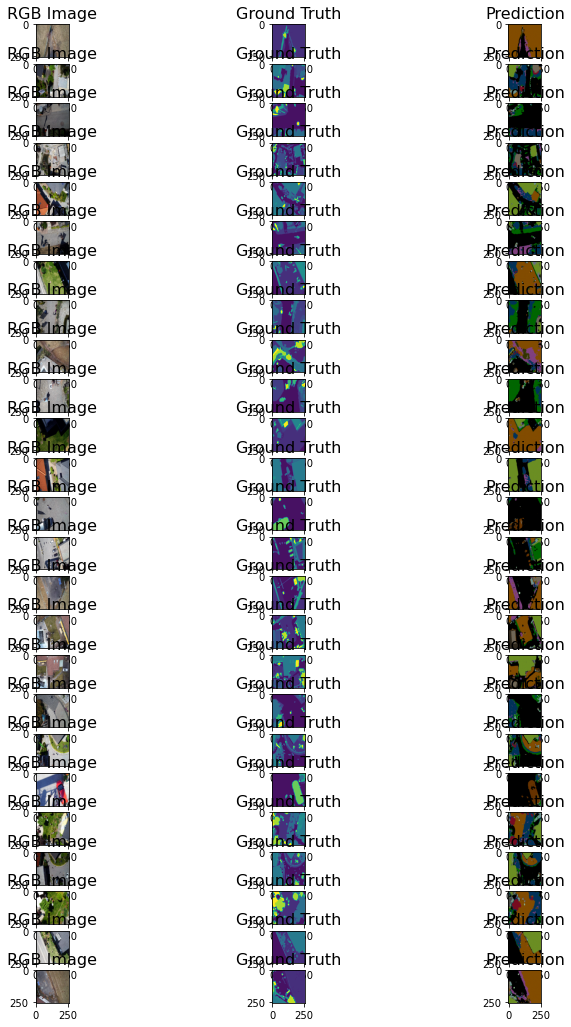

In [40]:
y_pred=model.predict(X_train)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(Y_train, axis=3)
fig, ax = plt.subplots(25, 3, figsize = (12,18))
for i in range(0,25):
    test_img_number = random.randint(0, X_train.shape[0]-1)
    test_img = X_train[test_img_number]
    ground_truth=Y_train[test_img_number]
    #print(ground_truth)
    #print(ground_truth.shape)
    ground_truth = np.argmax(ground_truth,axis=3)[:,:,0]
    #ground_truth=np.expand_dims(ground_truth,0)
    test_img_input=np.expand_dims(test_img, 0) 
    prediction = (model.predict(test_img_input)) 
    #print(prediction.shape)
    predicted_img=np.argmax(prediction, axis=3)[0,:,:] 
    #print(predicted_img.shape)
    #print(predicted_img)
    predicted_image=np.zeros((256,256,3))
    for k in range(256):
        for j in range(256):
            predicted_image[k][j][:]=labels[predicted_img[k][j]-1]
    #print(predicted_image.shape)
    predicted_image = predicted_image/255
    print(predicted_image.shape)
    print(type(predicted_image))
    #predicted_image=cv2.cvtColor(predicted_image,cv2.COLOR_BGR2RGB)
    ax[i,0].imshow(test_img)
    ax[i,0].set_title("RGB Image",fontsize=16)
    ax[i,1].imshow(ground_truth)
    ax[i,1].set_title("Ground Truth",fontsize=16)
    ax[i,2].imshow(predicted_image)
    ax[i,2].set_title("Prediction",fontsize=16)
    i+=1
    
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)
<class 'numpy.ndarray'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)
<class 'numpy.ndarray'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)
<class 'numpy.ndarray'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)
<class 'numpy.ndarray'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)
<class 'numpy.ndarray'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)
<class 'numpy.ndarray'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)
<class 'numpy.ndarray'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)
<class 'numpy.ndarray'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)
<class 'numpy.ndarray'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)
<class 'numpy.ndarray'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)
<class 'numpy.ndarray'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)
<class 'numpy.ndarray'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)
<class 'numpy.ndarray'>


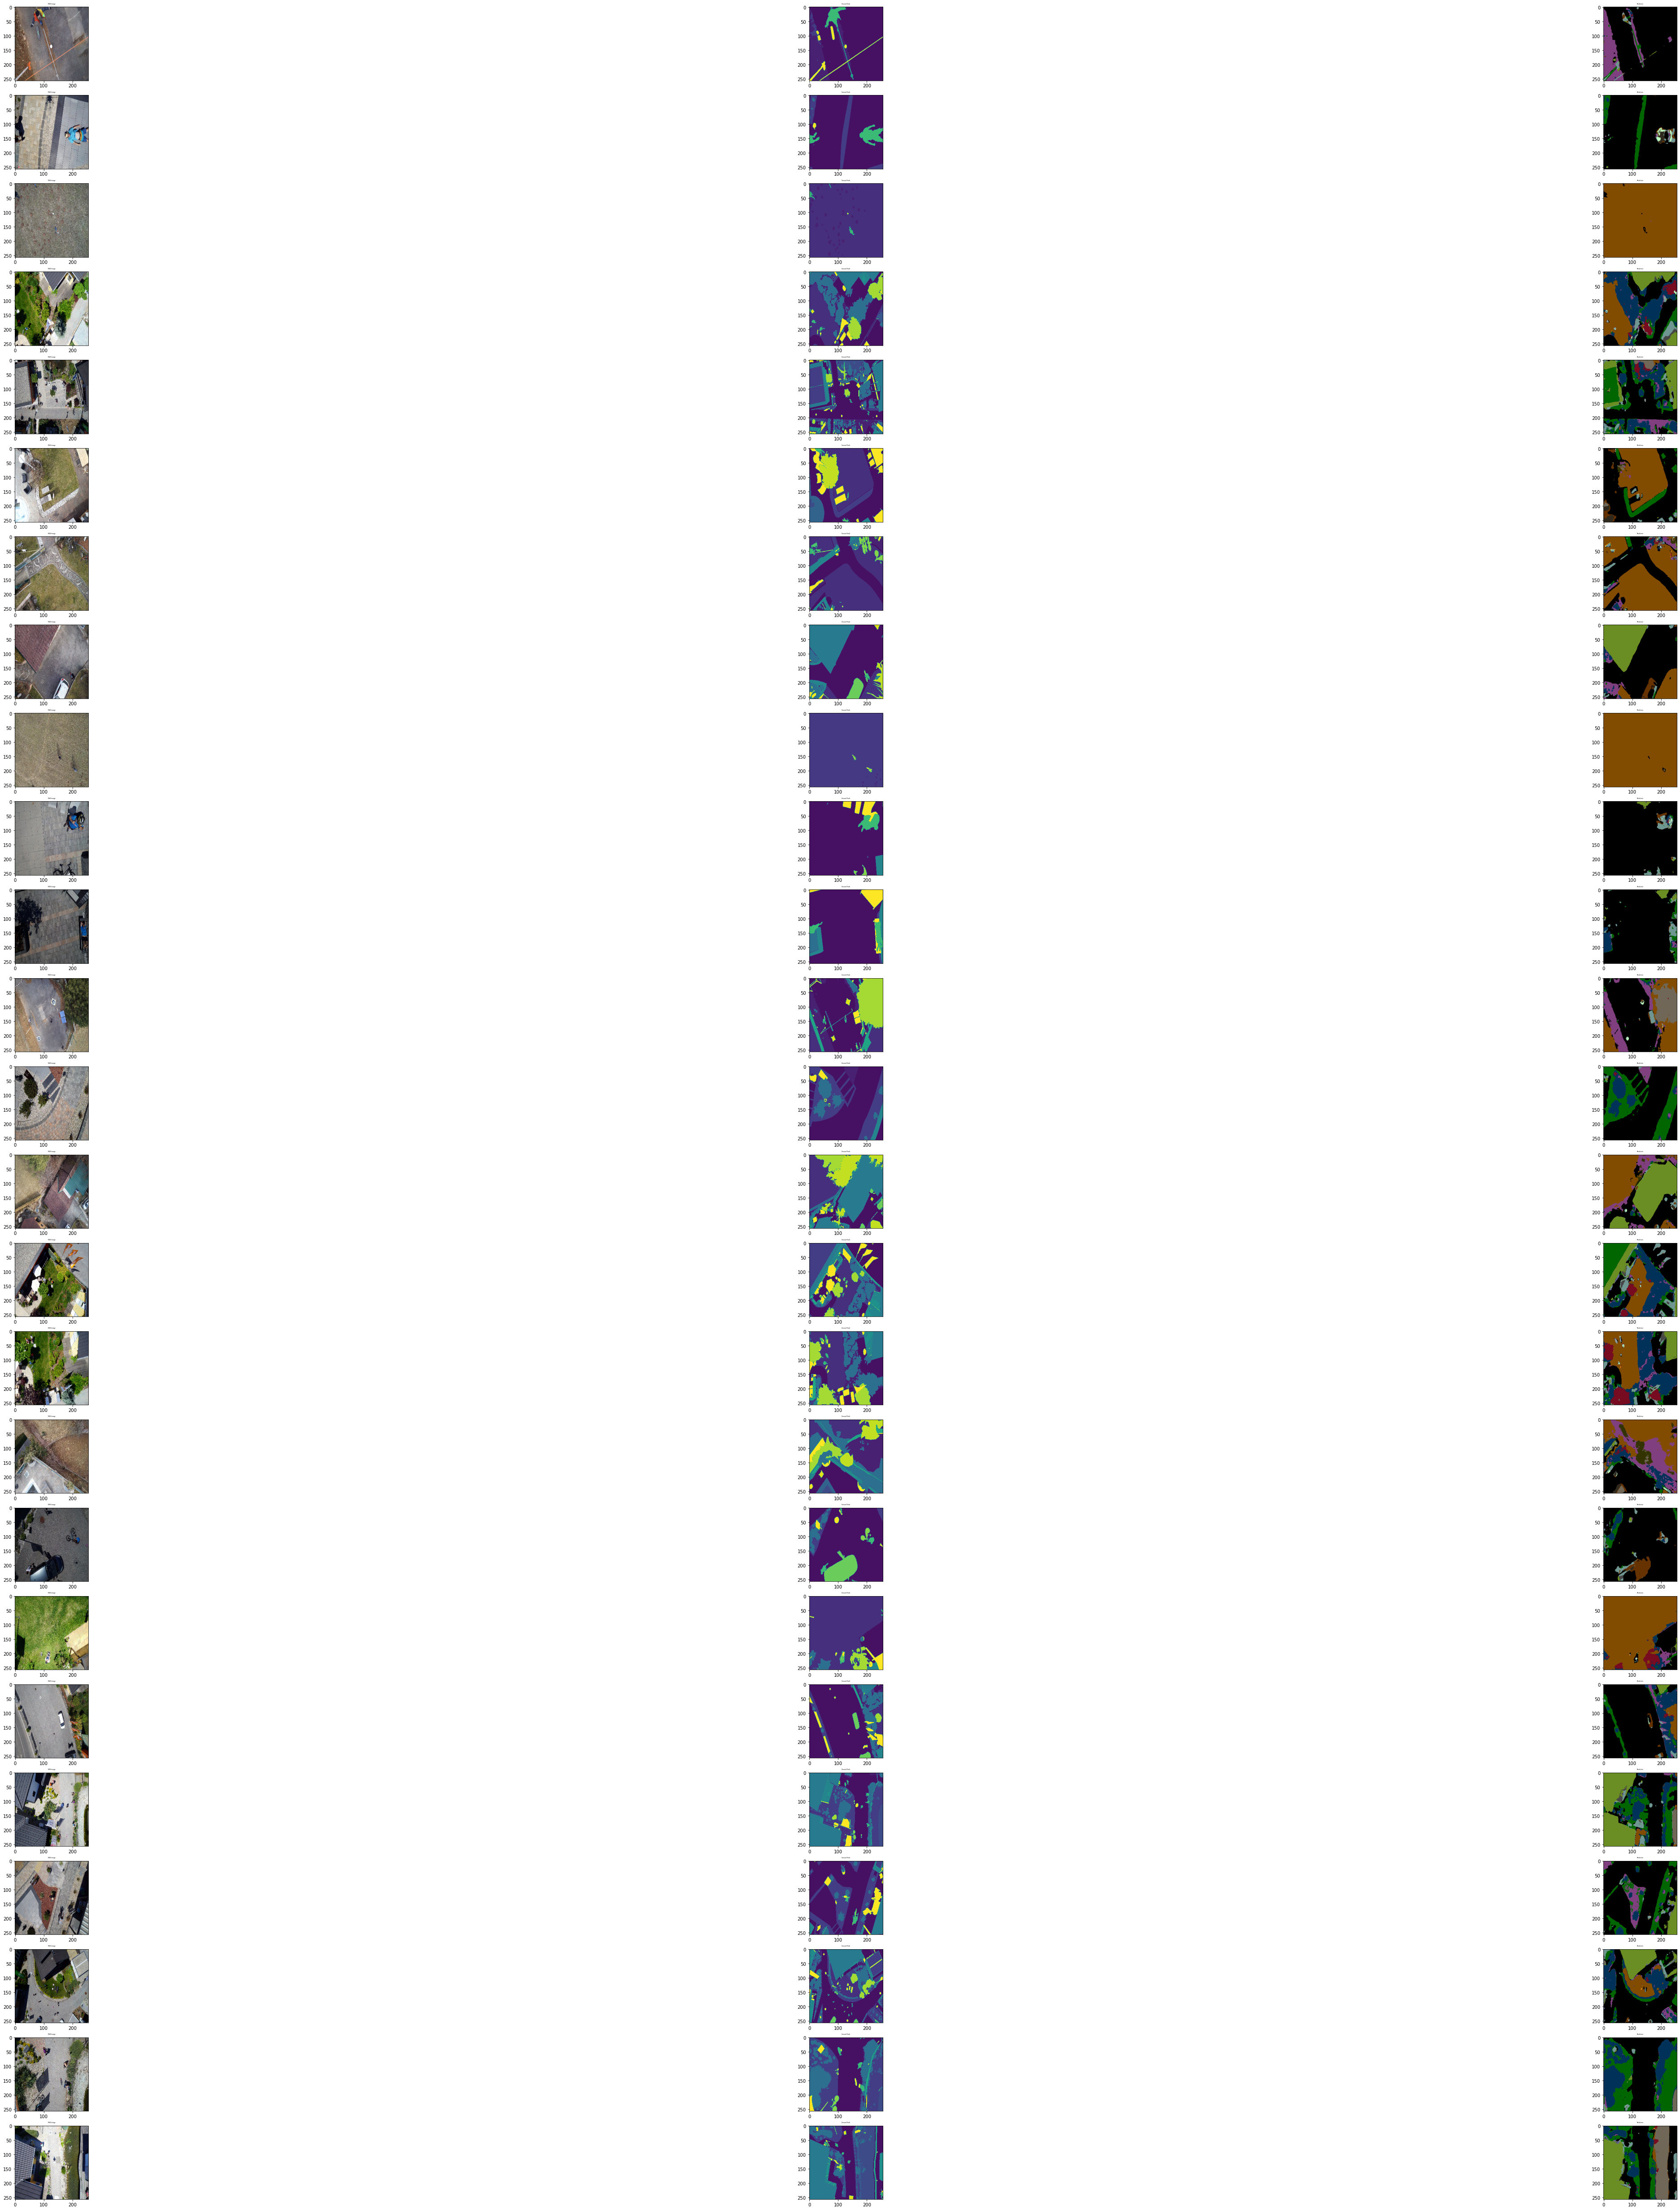

In [42]:
fig, ax = plt.subplots(25, 3, figsize = (90,90))
for i in range(0,25):
    test_img_number = random.randint(0, X_train.shape[0]-1)
    test_img = X_train[test_img_number]
    ground_truth=Y_train[test_img_number]
    #print(ground_truth)
    #print(ground_truth.shape)
    ground_truth = np.argmax(ground_truth,axis=3)[:,:,0]
    #ground_truth=np.expand_dims(ground_truth,0)
    test_img_input=np.expand_dims(test_img, 0) 
    prediction = (model.predict(test_img_input)) 
    #print(prediction.shape)
    predicted_img=np.argmax(prediction, axis=3)[0,:,:] 
    #print(predicted_img.shape)
    #print(predicted_img)
    predicted_image=np.zeros((256,256,3))
    for k in range(256):
        for j in range(256):
            predicted_image[k][j][:]=labels[predicted_img[k][j]-1]
    #print(predicted_image.shape)
    predicted_image = predicted_image/255
    print(predicted_image.shape)
    print(type(predicted_image))
    #predicted_image=cv2.cvtColor(predicted_image,cv2.COLOR_BGR2RGB)
    ax[i,0].imshow(test_img)
    ax[i,0].set_title("RGB Image",fontsize=3)
    ax[i,1].imshow(ground_truth)
    ax[i,1].set_title("Ground Truth",fontsize=3)
    ax[i,2].imshow(predicted_image)
    ax[i,2].set_title("Prediction",fontsize=3)
    i+=1
    
plt.show()